In [1]:
import mxnet as mx
import numpy as np
import os 
import json
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_finetune(symbol, arg_params, num_classes, layer_name='flatten0'):
    """
    symbol: the pretrained network symbol
    arg_params: the argument parameters of the pretrained model
    num_classes: the number of classes for the fine-tune datasets
    layer_name: the layer name before the last fully-connected layer
    """
    all_layers = symbol.get_internals()
    net = all_layers[layer_name+'_output']
    net = mx.symbol.FullyConnected(data=net, num_hidden=num_classes, name='fc1')
    net = mx.symbol.SoftmaxOutput(data=net, name='softmax')
    new_args = dict({k:arg_params[k] for k in arg_params if 'fc1' not in k})
    return (net, new_args)
    
def load_model(prefix):
    cwd = os.getcwd()
    path = cwd + '/pretrain/'
    symbol = mx.sym.load(path + '%s-symbol.json' % prefix)
    save_dict = mx.nd.load(path + '%s.params' % prefix)
    arg_params = {}
    aux_params = {}
    for k, v in save_dict.items():
        tp, name = k.split(':', 1)
        #print name
        if tp == 'arg':
            arg_params[name] = v
        if tp == 'aux':
            aux_params[name] = v
    return (symbol, arg_params, aux_params)

In [3]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def readcifar():
    #cwd = os.getcwd()
    dirpath = '/home/jiaming/下载/cifar-10-python/cifar-10-batches-py'
    
    x_train = np.zeros((10000,3072))
    y_train = []

    i = 0 
    for file in os.listdir(dirpath):
        name,ext = os.path.splitext(file)
        if len(ext) == 0:
            if name == 'test_batch':
                filepath = os.path.join(dirpath,file)
                result = unpickle(filepath)
                x_test = result[b'data']
                x_test = x_test.reshape(len(x_test),3,32,32)
                y_test = result[b'labels']
                y_test = np.array(y_test)
            else:
                filepath = os.path.join(dirpath,file)
                result = unpickle(filepath)

                if i == 0:
                   x_train = result[b'data']
                else:
                   x_train = np.concatenate((x_train,result[b'data']),axis=0)

                temp_y_train = result[b'labels']
                y_train += temp_y_train

                #print(result[b'data'].shape)
                #print(type(result[b'labels']))
                i = i + 1

    #print(x_train.shape)
    
    x_train = x_train.reshape(len(x_train),3,32,32)
    y_train = np.array(y_train)
    
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    
    x_train = (x_train-128) / 255
    x_test = (x_test-128) / 255
        
    return x_train,y_train,x_test,y_test

In [4]:
def generate_matrix_q(noise_level, n=10):
    q = np.random.rand(n, n).astype(np.float32)
    for j in range(n):
        q[j, j] = 1.0 - noise_level
        s = sum(q[:, j]) - q[j, j]
        for i in range(n):
            if i != j:
                q[i, j] = q[i, j] * noise_level / s
        q[:, j] /= sum(q[:, j])
    return q

def corrupt(labels, q):
    n = len(q)
    cdf = np.cumsum(q, axis=0)
    cdf[n - 1, :] = 1.0
    noisy_labels = []
    for y in labels:
        r = np.random.rand()
        for k in range(n):
            if r <= cdf[k, y]:
                noisy_labels.append(k)
                break
    assert len(noisy_labels) == len(labels)
    return noisy_labels

def get_label(name):
    cwd = os.getcwd()
    path = cwd + '/noisy_label/'
    
    if name == 'test':
        with open(path + 'test.json','r') as fp:
            rd = json.load(fp)
    else:
        with open(path + 'train.json','r') as fp:
            rd = json.load(fp)
    
    label = list(rd.values())
    files = list(rd.keys())
    return label,files

def cmplot(clean,noisy):
    LABELS = [
            "airplane",
            "automobile",
            "bird",
            "cat",
            "deer",
            "dog",
            "frog",
            "horse",
            "ship",
            "truck",
        ]
    num_output = len(LABELS)
    
    print("Accuracy: {}%".format(100*metrics.accuracy_score(clean, noisy)))
    print("Recall: {}%".format(100*metrics.recall_score(clean, noisy, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(clean, noisy, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(clean, noisy)
    # confusion_matrix = metrics.confusion_matrix(one_hot(y_test), predictions_one_hot)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")

    # Plot Results: 
    width = 8
    height = 8
    
    plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(num_output)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

    

Accuracy: 100.0%
Recall: 100.0%
f1_score: 100.0%

Confusion Matrix:
[[5000    0    0    0    0    0    0    0    0    0]
 [   0 5000    0    0    0    0    0    0    0    0]
 [   0    0 5000    0    0    0    0    0    0    0]
 [   0    0    0 5000    0    0    0    0    0    0]
 [   0    0    0    0 5000    0    0    0    0    0]
 [   0    0    0    0    0 5000    0    0    0    0]
 [   0    0    0    0    0    0 5000    0    0    0]
 [   0    0    0    0    0    0    0 5000    0    0]
 [   0    0    0    0    0    0    0    0 5000    0]
 [   0    0    0    0    0    0    0    0    0 5000]]

Confusion matrix (normalised to % of total test data):
[[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 10.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. 10.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. 10.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. 10.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. 10.  0.  0.]
 

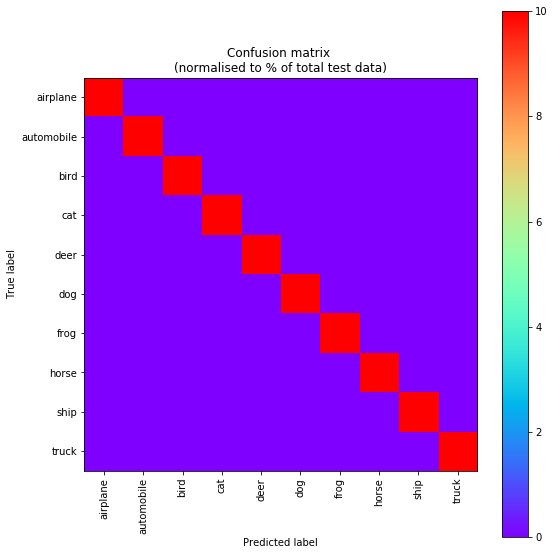

50000 50000 50000


In [6]:
if __name__ == '__main__':
    #x_train,y_train,x_test,y_test = readcifar()
    q = generate_matrix_q(0.33)
    labels,files = get_label('train')
    noisy_labels = corrupt(labels,q)
    cmplot(labels,noisy_labels)
    noisy_as_clean_labels = labels[:10000] + noisy_labels[10000:]
    noisy_as_none_labels = labels[:10000] + [-1] * 40000
    clean_as_none_labels = [-1] * 10000 + noisy_labels[10000:]
    print(len(noisy_as_clean_labels),len(noisy_as_none_labels),len(clean_as_none_labels))
    
    #print(noisy_as_none_labels)
#     merged = zip(files, noisy_as_clean_labels, noisy_as_none_labels, clean_as_none_labels)
#     print(merged)
#     np.random.shuffle(merged)
#     files, nacl, nanl, canl = zip(*merged)
#     print(files)
    